## Standardize, augment,etc

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

import os
import json
import time
import math

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


In [2]:
COL_NAMES = ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change']
filepath = "btc_apr_1_2012_to_apr_14_2019.csv"
df = pd.read_csv(filepath, thousands=',', names=COL_NAMES, index_col="Date", parse_dates=True, header=0)

assert(df.isnull().values.any()==False)

df.sort_index(ascending=True, inplace=True)

df = df[(df.index >= '2017-01-01')]
df['Volume'] = df['Volume'].apply(lambda x: float(x[:-1]))
df['Change'] = df['Change'].apply(lambda x: float(x[:-1]))
df.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41.15,3.33
2017-01-02,1017.0,995.4,1031.7,990.2,64.95,2.17
2017-01-03,1033.3,1017.0,1035.5,1006.5,54.79,1.60
2017-01-04,1135.4,1033.3,1148.5,1022.3,156.27,9.88
2017-01-05,989.3,1135.4,1150.6,874.5,240.01,-12.86


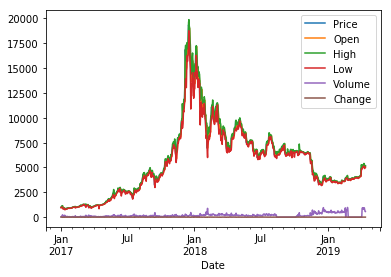

In [3]:
df.plot()

# Preprocess and Augment the data

In [7]:
import statsmodels.api as sm
import ta as ta
from statsmodels.tsa.statespace.varmax import VARMAX
from pykalman import KalmanFilter

data = df[['Price', 'Open', 'High', 'Low', 'Volume', 'Change']]

# Seasonal, Residual, Trend
s = sm.tsa.seasonal_decompose(np.flip(data['Price'].values), freq=60)
data['Trend'] = s.trend
data['Seasonal'] = s.seasonal
data['Residual'] = s.resid

# Technical Indicators
data['rsi'] = ta.momentum.rsi(data['Price'])
data['mfi'] = ta.momentum.money_flow_index(data['High'], data['Low'], data['Price'], data['Volume'])
data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Price'], data['Volume'])
data['vpt'] = ta.volume.volume_price_trend(data['Price'], data['Volume'])
data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Price'])
data['bb'] = ta.volatility.bollinger_hband(data['Price'])

# Simple Average
data['MovingAverage30'] = data['Price'].rolling(window=30).mean()
data['MovingAverage50'] = data['Price'].rolling(window=50).mean()
data['MovingAverage100'] = data['Price'].rolling(window=100).mean()
data['MovingAverage200'] = data['Price'].rolling(window=100).mean()

# Varmax residuals
model = VARMAX(endog=np.asarray(data[['Price', 'Open', 'High', 'Low', 'Volume', "Change"]]))
model_fit = model.fit()
data['VAR_Price'] = model_fit.resid[:, 0]
data['VAR_Open'] = model_fit.resid[:, 1]
data['VAR_High'] = model_fit.resid[:, 2]
data['VAR_Low'] = model_fit.resid[:, 3]
data['VAR_Price'] = model_fit.resid[:, 4]
data['VAR_Change'] = model_fit.resid[:, 5]

# Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
measurements = data[['Price']].values
results = kf.em(measurements).smooth(measurements)
data['Kalman'] = results[0]

TypeError: shift() got an unexpected keyword argument 'fill_value'

In [5]:
data.plot()

NameError: name 'data' is not defined

In [36]:
# Standardize data
scaler = StandardScaler()
data[data.columns] = scaler.fit(data).transform(data)
data = pd.DataFrame(data)

In [25]:
# # Scale data
# scaler1 = MinMaxScaler(feature_range=(0, 1))
# data[data.columns[list(data.min() >= 0)]] = scaler1.fit_transform(data[data.columns[list(data.min() >= 0)]])
# data = pd.DataFrame(data)

# scaler2 = MinMaxScaler(feature_range=(-1, 1))
# data[data.columns[list(data.min() < 0)]] = scaler2.fit_transform(data[data.columns[list(data.min() < 0)]])

In [37]:
data = data.fillna(0)

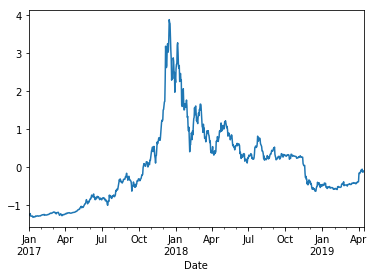

In [39]:
data['Price'].plot()

In [38]:
data.to_csv('data_25.csv')